In [26]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from keras import backend as K
from sklearn.preprocessing import MultiLabelBinarizer
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import RMSprop
from keras.utils.vis_utils import plot_model
from keras.preprocessing.image import img_to_array
from tensorflow.keras.callbacks import EarlyStopping

from ipynb.fs.full.model import *
import os
#print(os.listdir("./input"))
import pickle

import os
import numpy as np
from tqdm import tqdm
from fastai import *
import torch

%matplotlib inline

import cv2
import pandas as pd
import splitfolders
import random

In [5]:
data = os.listdir("./input")
len(data)

82

In [7]:
 def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True    

SEED = 999
seed_everything(SEED)

In [9]:
## one time done
##splitfolders.ratio('./input', output="./output", seed=SEED, ratio=(.7, .3)) 

In [10]:
#Initialize parametres

EPOCHS = 3
BS = 100 #Batch size
LR = 1e-3 #Learning rate 0.001
img_dim = (45,45,3)
train_data_dir = './output/train'
test_data_dir = './output/val'
labels = []
#Nbr of training images
train_samples_nbr  = sum(len(files) for _, _, files in os.walk(r'./output/train'))
print(f"Number of train images are {train_samples_nbr}")
#Nbr of testing images
test_samples_nbr  = sum(len(files) for _, _, files in os.walk(r'./output/val'))
print(f"Number of test images are {test_samples_nbr}")

Number of train images are 263143
Number of test images are 112831


In [13]:
# Infos about our Dataset
nbr_of_pictures = []

labels = os.listdir("./input")
for _, _, files in os.walk(r'./input'):
    nbr_of_pictures.append(len(files))

nbr_of_pictures=nbr_of_pictures[1:]
#print nbr of pictures in every class
print("Number of samples in every class ...")
for i in range(82):  # 82 : Nbr of classes
    print(labels[i]," : ",nbr_of_pictures[i])

Number of samples in every class ...
!  :  1300
(  :  14294
)  :  14355
+  :  25112
,  :  1906
-  :  33997
0  :  6914
1  :  26520
2  :  26141
3  :  10909
4  :  7396
5  :  3545
6  :  3118
7  :  2909
8  :  3068
9  :  3737
=  :  13104
A  :  12367
alpha  :  2546
ascii_124  :  1339
b  :  8651
beta  :  2025
C  :  5802
cos  :  2986
d  :  4852
Delta  :  137
div  :  868
e  :  3003
exists  :  21
f  :  3712
forall  :  45
forward_slash  :  199
G  :  1692
gamma  :  409
geq  :  693
gt  :  258
H  :  1464
i  :  5140
in  :  47
infty  :  1783
int  :  2742
j  :  1536
k  :  3074
l  :  1017
lambda  :  109
ldots  :  609
leq  :  973
lim  :  1675
log  :  2001
lt  :  477
M  :  2476
mu  :  177
N  :  10862
neq  :  558
o  :  449
p  :  2680
phi  :  355
pi  :  2332
pm  :  802
prime  :  329
q  :  1230
R  :  2671
rightarrow  :  1703
S  :  1413
sigma  :  201
sin  :  4293
sqrt  :  8908
sum  :  2689
T  :  3274
tan  :  2450
theta  :  2796
times  :  3251
u  :  1269
v  :  1558
w  :  556
X  :  26594
y  :  9340
z  :  5870
[ 

In [14]:
# Checking image data format

if K.image_data_format() == 'channels_first':
    input_shape = (img_dim[2], img_dim[0], img_dim[1])
else:
    input_shape = (img_dim[0], img_dim[1], img_dim[2])
print(input_shape)

(45, 45, 3)


In [16]:
print(len(labels)," Classes : ",labels)
labels = np.array(labels)
print(labels)

82  Classes :  ['!' '(' ')' '+' ',' '-' '0' '1' '2' '3' '4' '5' '6' '7' '8' '9' '=' 'A'
 'alpha' 'ascii_124' 'b' 'beta' 'C' 'cos' 'd' 'Delta' 'div' 'e' 'exists'
 'f' 'forall' 'forward_slash' 'G' 'gamma' 'geq' 'gt' 'H' 'i' 'in' 'infty'
 'int' 'j' 'k' 'l' 'lambda' 'ldots' 'leq' 'lim' 'log' 'lt' 'M' 'mu' 'N'
 'neq' 'o' 'p' 'phi' 'pi' 'pm' 'prime' 'q' 'R' 'rightarrow' 'S' 'sigma'
 'sin' 'sqrt' 'sum' 'T' 'tan' 'theta' 'times' 'u' 'v' 'w' 'X' 'y' 'z' '['
 ']' '{' '}']
['!' '(' ')' '+' ',' '-' '0' '1' '2' '3' '4' '5' '6' '7' '8' '9' '=' 'A'
 'alpha' 'ascii_124' 'b' 'beta' 'C' 'cos' 'd' 'Delta' 'div' 'e' 'exists'
 'f' 'forall' 'forward_slash' 'G' 'gamma' 'geq' 'gt' 'H' 'i' 'in' 'infty'
 'int' 'j' 'k' 'l' 'lambda' 'ldots' 'leq' 'lim' 'log' 'lt' 'M' 'mu' 'N'
 'neq' 'o' 'p' 'phi' 'pi' 'pm' 'prime' 'q' 'R' 'rightarrow' 'S' 'sigma'
 'sin' 'sqrt' 'sum' 'T' 'tan' 'theta' 'times' 'u' 'v' 'w' 'X' 'y' 'z' '['
 ']' '{' '}']


In [17]:
earlyStopping = EarlyStopping(monitor="val_loss", mode="min", patience=2)

In [18]:
print("[INFO] class labels:")
mlb = MultiLabelBinarizer()
labels = mlb.fit_transform(labels)
print(labels)

[INFO] class labels:
[[1 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 0 1]]


In [19]:
# Building the model 
model = VGGNet.build(
    width=img_dim[1], height=img_dim[0],
    depth=img_dim[2], classes=82,
    activFct="softmax") #for multi-class classification
model.summary()
print('Number of layers of our model : ',len(model.layers))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 44, 44, 32)        416       
_________________________________________________________________
activation (Activation)      (None, 44, 44, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 22, 22, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 21, 21, 32)        4128      
_________________________________________________________________
activation_1 (Activation)    (None, 21, 21, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 10, 10, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 9, 9, 64)          8

In [20]:

opt = Adam(learning_rate=LR, decay=LR / EPOCHS)

In [21]:
# Compiling the model 
#import tensorflow.python.keras.optimizer_v2.adam.Adam
#opt = RMSprop(lr=LR, rho=0.9, epsilon=None, decay=0.0)
model.compile(loss='categorical_crossentropy',
              optimizer="adam",
              metrics=['accuracy']) 


In [22]:
# data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.0,
    zoom_range=0.0,
    featurewise_center=False,# set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    rotation_range=0.0,  # randomly rotate images in the range (deg 0 to 180)
    width_shift_range=0.0,  # randomly shift images horizontally
    height_shift_range=0.0,  # randomly shift images vertically
    horizontal_flip=False,  # randomly flip images
    vertical_flip=False
    )

# data augmentation for testing
test_datagen = ImageDataGenerator(rescale=1. / 255)

In [23]:

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_dim[0], img_dim[1]),
    batch_size=BS,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_dim[0], img_dim[1]),
    batch_size=BS,
    class_mode='categorical')


Found 263143 images belonging to 82 classes.
Found 112831 images belonging to 82 classes.


In [24]:
# Training
history = model.fit(
    train_generator,
    steps_per_epoch=train_samples_nbr // BS,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=test_samples_nbr // BS,
    callbacks=[earlyStopping])


Epoch 1/3
2631/2631 [==============================] - 6422s 2s/step - loss: 1.6292 - accuracy: 0.5743 - val_loss: 0.6868 - val_accuracy: 0.8116
Epoch 2/3
2631/2631 [==============================] - 5985s 2s/step - loss: 1.0800 - accuracy: 0.6981 - val_loss: 0.5221 - val_accuracy: 0.8526
Epoch 3/3
2631/2631 [==============================] - 8004s 3s/step - loss: 0.9154 - accuracy: 0.7405 - val_loss: 0.4659 - val_accuracy: 0.8646


In [27]:
# plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True);
# save the model to disk
print("[INFO] serializing network...")
#model.save(args["model"])
model.save("model.model")
model.save_weights("weights.h5")
#save the multi-label binarizer to disk
print("[INFO] serializing label binarizer...")
# f = open(args["labelbin"], "wb")
f = open("labels.pickle", "wb")
f.write(pickle.dumps(mlb))
f.close()


[INFO] serializing network...
INFO:tensorflow:Assets written to: model.model\assets
[INFO] serializing label binarizer...


In [29]:
#probabilities = model.predict_generator(validation_generator,2000)

# Evaluating the model / Get Validation accuracy on sample from validation set
scores = model.evaluate(validation_generator,verbose=1) 
print("Accuracy = ", scores[1])


1129/1129 [==============================] - 711s 630ms/step - loss: 0.4659 - accuracy: 0.8646
Accuracy =  0.8646382689476013


In [30]:
import matplotlib.pyplot as plt

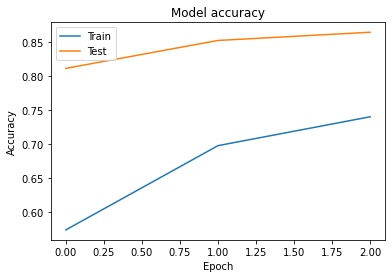

In [32]:


# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig('model_accuary_plot.png')
plt.show()


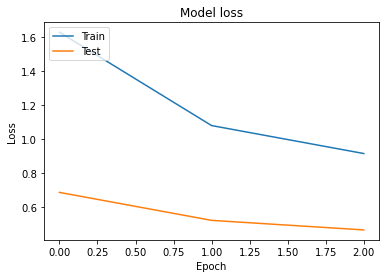

In [33]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig('model_loss_plot.png')
plt.show()


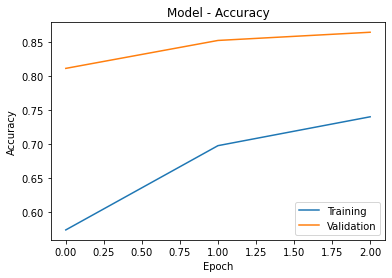

In [35]:
# Train - Val plot
fig1, ax_acc = plt.subplots()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model - Accuracy')
plt.legend(['Training', 'Validation'], loc='lower right')
plt.savefig("train_val_plot.png")